Predictive Modeling

1. Individual Prediction


--- Part 1: Individual Trend Analysis ---
bobette.riner@ipgdirect.com: R² = 0.022


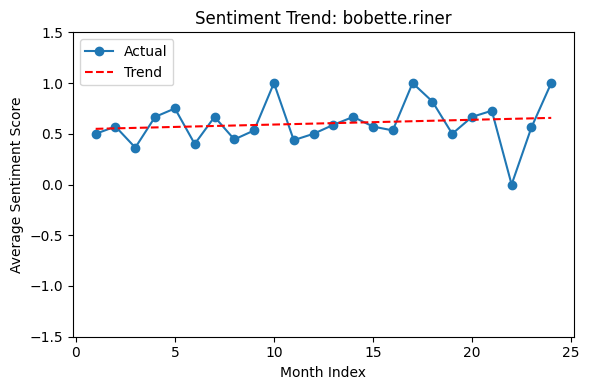

don.baughman@enron.com: R² = 0.000


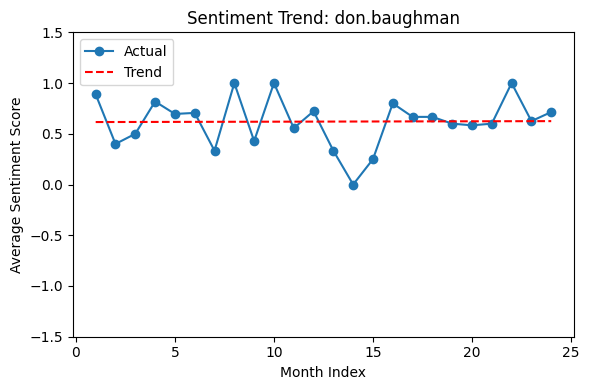

eric.bass@enron.com: R² = 0.013


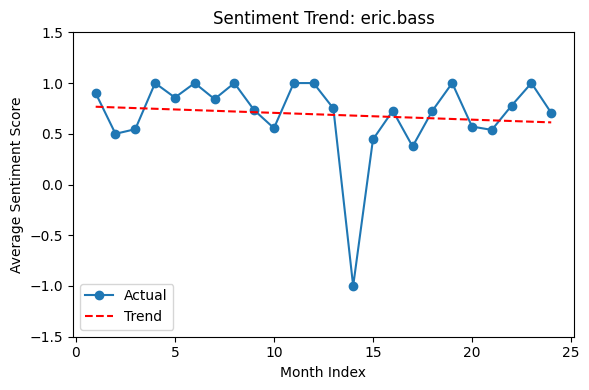

john.arnold@enron.com: R² = 0.365


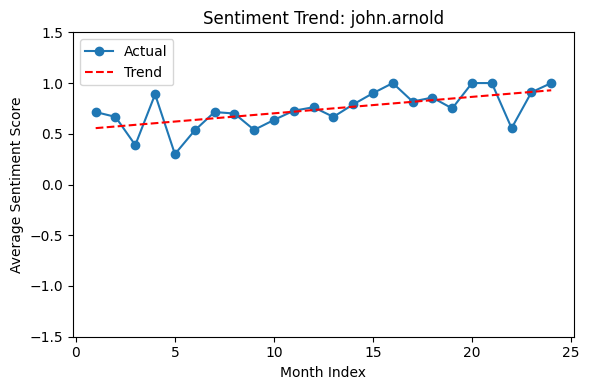

johnny.palmer@enron.com: R² = 0.000


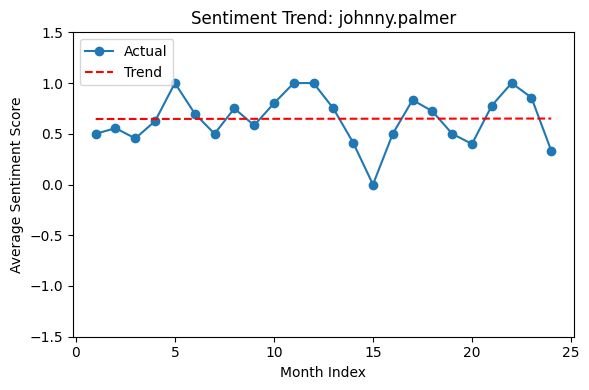

kayne.coulter@enron.com: R² = 0.036


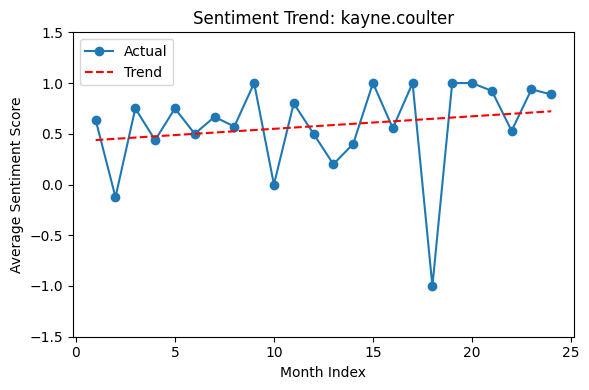

lydia.delgado@enron.com: R² = 0.018


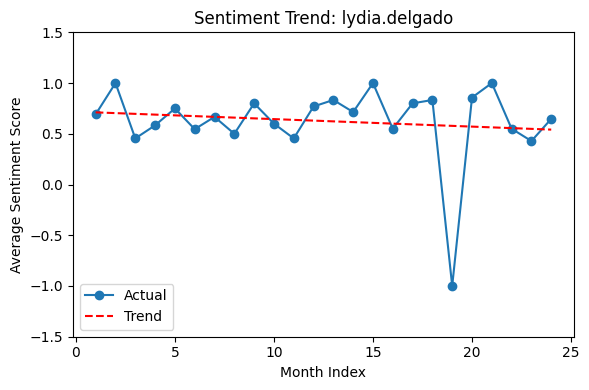

patti.thompson@enron.com: R² = 0.046


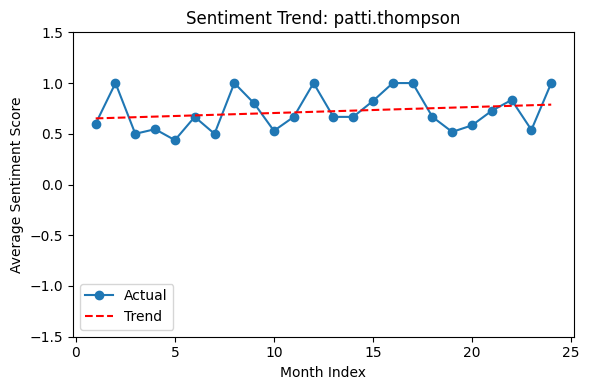

rhonda.denton@enron.com: R² = 0.020


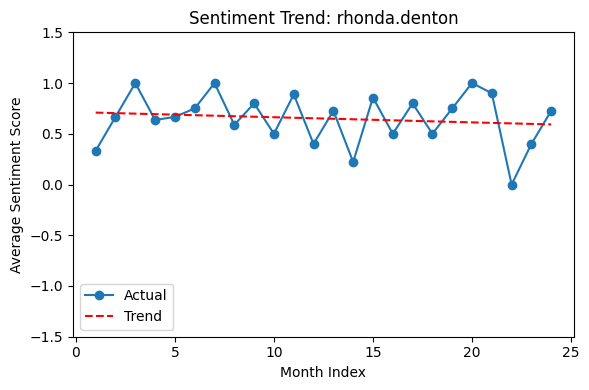

sally.beck@enron.com: R² = 0.001


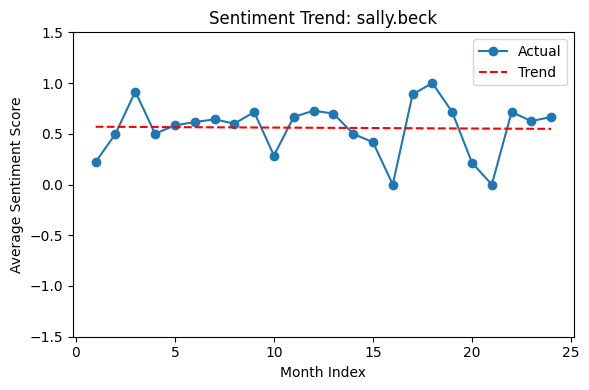

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load preprocessed message-level dataset
df = pd.read_csv('sentimental_labeling.csv')
df.columns = df.columns.str.strip().str.lower()
df['timestamp'] = pd.to_datetime(df['date'])
df['length'] = df['text'].astype(str).str.len()

sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['score'] = df['sentiment'].map(sentiment_map)

# =========================
# Part 1: Per-Employee Regression
# =========================
df['year_month'] = df['timestamp'].dt.to_period('M').astype(str)
df['month_index'] = pd.to_datetime(df['year_month']).rank(method='dense').astype(int)

monthly_avg = (
    df.groupby(['from', 'year_month'])['score']
    .mean()
    .reset_index()
    .rename(columns={'from': 'employee', 'score': 'average_score'})
)

monthly_avg['month_index'] = pd.to_datetime(monthly_avg['year_month']).rank(method='dense').astype(int)

print("\n--- Part 1: Individual Trend Analysis ---")

for emp in monthly_avg['employee'].unique():
    emp_data = monthly_avg[monthly_avg['employee'] == emp]
    if len(emp_data) < 4:
        continue
    X = emp_data[['month_index']]
    y = emp_data['average_score']
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    r2 = r2_score(y, y_pred)
    print(f"{emp}: R² = {r2:.3f}")  
    
    plt.figure(figsize=(6, 4))
    plt.plot(X, y, marker='o', label='Actual')
    plt.plot(X, y_pred, '--r', label='Trend')
    plt.title(f"Sentiment Trend: {emp.split('@')[0]}")
    plt.xlabel('Month Index')
    plt.ylabel('Average Sentiment Score')
    plt.ylim(-1.5, 1.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

In this part, a separate regression model was trained for each employee to predict monthly sentiment scores based solely on time (month index).
The R² scores for most employees were low, primarily because sentiment trends are inherently noisy, and individuals may not follow consistent patterns month over month. The high variance in each employee's emotional trajectory weakens the predictive power of a simple linear model.

2. Prediction: Message Length vs Average Score

Due to the discrete nature of sentiment labels (-1, 0, 1), direct regression on individual messages is not meaningful. Instead, we grouped messages into length bins and calculated the average sentiment score per bin to smooth out noise and better reflect underlying tendencies.
The resulting model achieved a moderate R², indicating a noticeable, though not strongly linear, relationship between message length and sentiment tone. Outliers—very long or very short messages—appear to contribute to some fluctuation in the average score, potentially skewing the regression.


--- Part 2: Length Regression ---
R² Score for Length vs Avg Score: 0.3593


C:\Users\xiaob\AppData\Local\Temp\ipykernel_43424\4241557405.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df.groupby('length_bin')['score'].mean().reset_index()


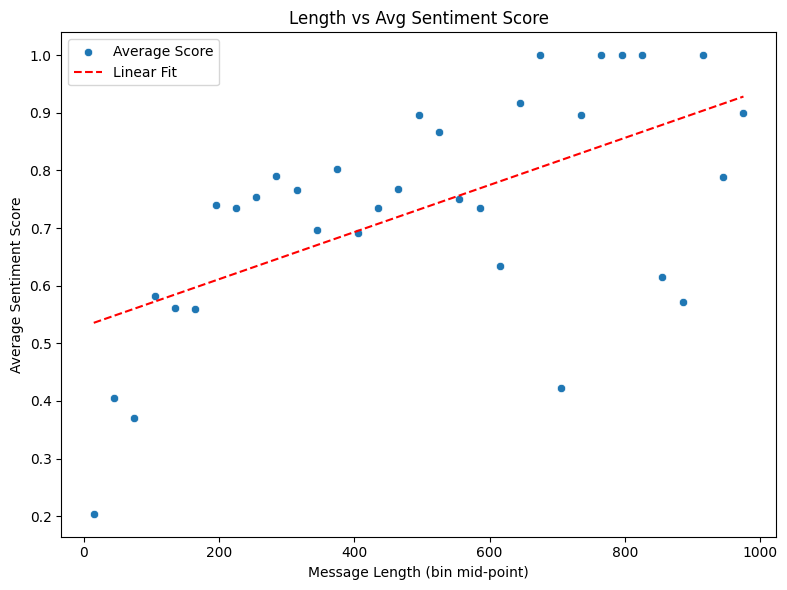

In [26]:
df['length_bin'] = pd.cut(df['length'], bins=range(0, 1001, 30)) 
binned = df.groupby('length_bin')['score'].mean().reset_index()
binned['bin_mid'] = binned['length_bin'].apply(lambda x: x.mid)


X = binned[['bin_mid']]
y = binned['score']
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)  # ✅ R² for length model
print(f"\n--- Part 2: Length Regression ---")
print(f"R² Score for Length vs Avg Score: {r2:.4f}")


plt.figure(figsize=(8, 6))
sns.scatterplot(x='bin_mid', y='score', data=binned, label='Average Score')
plt.plot(binned['bin_mid'], y_pred, '--r', label='Linear Fit')
plt.xlabel('Message Length (bin mid-point)')
plt.ylabel('Average Sentiment Score')
plt.title('Length vs Avg Sentiment Score')
plt.legend()
plt.tight_layout()
plt.show()


In this part, a separate regression model was trained for each employee to predict monthly sentiment scores based solely on time (month index).
The R² scores for most employees were low, primarily because sentiment trends are inherently noisy, and individuals may not follow consistent patterns month over month. The high variance in each employee's emotional trajectory weakens the predictive power of a simple linear model.

3. Frequency vs Average Sentimental Score

✅ Frequency-Based Score Prediction
MSE: 0.0183
R²: 0.6047


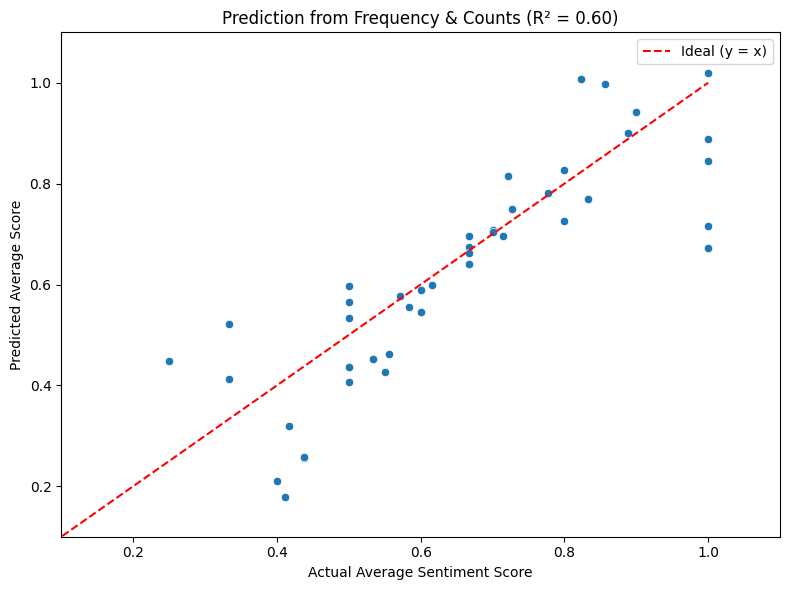

In [30]:
df = pd.read_csv('employee_scores.csv')

# 特征与标签
X = df[['message_count', 'positive_count', 'negative_count']]
y = df['average_score']

# 拆分训练/测试
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 建模
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 评估
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Frequency-Based Score Prediction")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

# 可视化真实 vs 预测
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', label='Ideal (y = x)')
plt.xlabel('Actual Average Sentiment Score')
plt.ylabel('Predicted Average Score')
plt.ylim(0.1,1.1)
plt.xlim(0.1,1.1)
plt.title(f'Prediction from Frequency & Counts (R² = {r2:.2f})')
plt.legend()
plt.tight_layout()
plt.show()

The third model used features such as message count, positive message count, and negative message count to predict average monthly sentiment scores.
This model performed the best among the three, with the highest R², suggesting a strong relationship between message frequency and emotional tone.
Intuitively, employees who send more positive messages tend to have a higher average score, and vice versa for negative messages. The frequency and emotional composition of communication thus offer reliable signals for understanding engagement trends.